 In this Question we will experiment with a few publicly available generative models

# Warm-up Face interpolation (there is no question here and you can skip this section if you want)

In [1]:
import torch
use_gpu = True if torch.cuda.is_available() else False

# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 512 x 512 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celebAHQ-512',
                       pretrained=True, useGPU=use_gpu)

Downloading: "https://github.com/facebookresearch/pytorch_GAN_zoo/zipball/hub" to /home/wa_ziqia/.cache/torch/hub/hub.zip
Downloading: "https://dl.fbaipublicfiles.com/gan_zoo/PGAN/celebaHQ16_december_s7_i96000-9c72988c.pth" to /home/wa_ziqia/.cache/torch/hub/checkpoints/celebaHQ16_december_s7_i96000-9c72988c.pth


  0%|          | 0.00/264M [00:00<?, ?B/s]

Average network found !


In [2]:

print(model.netG)

DataParallel(
  (module): GNet(
    (scaleLayers): ModuleList(
      (0): ModuleList(
        (0): EqualizedConv2d(
          (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): EqualizedConv2d(
          (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (1): ModuleList(
        (0): EqualizedConv2d(
          (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): EqualizedConv2d(
          (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (2): ModuleList(
        (0): EqualizedConv2d(
          (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): EqualizedConv2d(
          (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (3): ModuleList(
        (0): EqualizedConv2d(
          (module): Con

We will visualize some randomly generated faces. Run this cell a few times to generate new faces

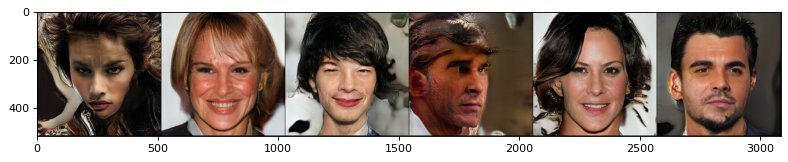

In [5]:
num_images = 6
noise, _ = model.buildNoiseData(num_images)
with torch.no_grad():
    generated_images = model.netG(noise).detach()

# let's plot these images using torchvision and matplotlib
import matplotlib.pyplot as plt
import torchvision

grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.figure(figsize=(12, 6), dpi=80)

plt.imshow(grid.permute(1, 2, 0).cpu().numpy())


In [6]:
print(noise.shape)
print(generated_images.shape)

torch.Size([6, 512])
torch.Size([6, 3, 512, 512])


Here we find two random faces images and their noise and writea function that will interpolate between two randomly generated faces. It will take a noise vector of size 2x512. Let's denote noise_1 and noise_2 the first and 2nd row. As above create 8 intermediate values that interpolate between them. 

e.g. if we had just one intermediate value we would end up with  noise_1, (noise_1+noise_2)/2, noise_2

we pass these through the generator (e.g. by putting them in a 8x512 noise tensor) and visualize the interpolation.

Note: again there is nothing to do here it is just an example to help you understand the next part

torch.Size([10, 512])
torch.Size([3, 1030, 4114])


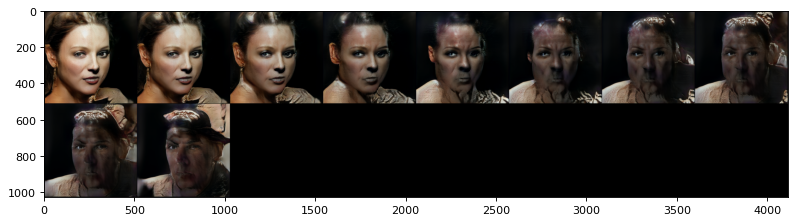

In [7]:
num_images = 2
noise, _ = model.buildNoiseData(num_images)
alpha = [0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.0]

noises = [noise[0]*a+noise[1]*(1.0-a) for a in alpha]
noises = torch.vstack(noises)
print(noises.shape)
with torch.no_grad():
    generated_images = model.netG(noises).detach()

# let's plot these images using torchvision and matplotlib
import matplotlib.pyplot as plt
import torchvision

grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.figure(figsize=(12, 6), dpi=80)

plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
print(grid.shape)

# Big-GAN interpolations (25 points)

2. We will now experiment with the bigGAN model trained on natural images. You can find the implementation and further documentation here https://github.com/huggingface/pytorch-pretrained-BigGAN. Run the cells below to download the model and generate some random images.

In [9]:
!pip install pytorch-pretrained-biggan
!pip install libsixel-python
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/wa_ziqia/nltk_data...


True

In [10]:
import torch
from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names, truncated_noise_sample,
                                       save_as_images, display_in_terminal)
import matplotlib.pyplot as plt
import torchvision


# Load pre-trained model tokenizer (vocabulary)
model = BigGAN.from_pretrained('biggan-deep-256')

# Prepare a input
truncation = 0.4
class_vector = one_hot_from_names(['soap bubble', 'coffee', 'mushroom','fox','dog','lion'], batch_size=3)
noise_vector = truncated_noise_sample(truncation=truncation, batch_size=6)

# All in tensors
noise_vector = torch.from_numpy(noise_vector)
class_vector = torch.from_numpy(class_vector)

# If you have a GPU, put everything on cuda
noise_vector = noise_vector.to('cuda')
class_vector = class_vector.to('cuda')
model.to('cuda')

# Generate an image
with torch.no_grad():
    output = model(noise_vector, class_vector, truncation)

# If you have a GPU put back on CPU
output = output.to('cpu')

100%|█████████████████████████| 715/715 [00:00<00:00, 377508.48B/s]


We visualize the generated images

torch.Size([6, 128])
torch.Size([6, 1000])


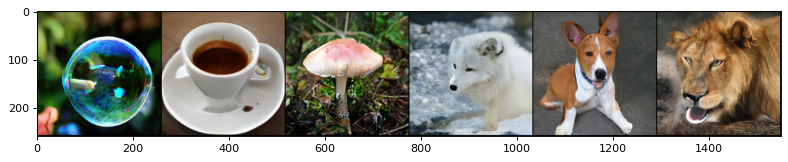

In [11]:
output.shape
print(noise_vector.shape)
print(class_vector.shape)
plt.figure(figsize=(12, 6), dpi=80)
grid = torchvision.utils.make_grid(output.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())

Let's experiment with interpolating between different images in this model as we did in the face images. Note the BigGAN takes both a class vector and a random noise. 
(a) Sample two random images from the same category such as "dog" and interpolate between them with 8 intermediate steps and using the same class vector
(b) Sample two random images from two diff classes (e.g. "dog" and "mushroom") and interpolate between them. For the class conditionin variable you may interpolate between these as well for best results.

Feel free to try other combinations and categories.

Example of what your answer shoudl look like are below. however you should show it for a different images then the ones below (And different ones than your classmates :))

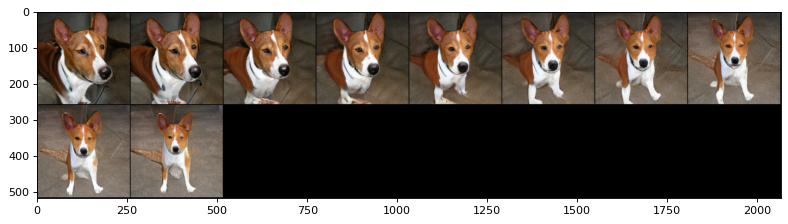

In [14]:
import numpy as np

def interpolate_images(model, class_name, num_intermediate_steps=8, truncation=0.4):
    # Prepare input
    class_vector = one_hot_from_names([class_name], batch_size=1)
    noise_vectors = truncated_noise_sample(truncation=truncation, batch_size=2)

    alpha = np.linspace(0, 1, num_intermediate_steps + 2)  
    interpolated_noise_vectors = [(1 - a) * noise_vectors[0] + a * noise_vectors[1] for a in alpha]
    interpolated_noise_vectors = torch.tensor(interpolated_noise_vectors)

    # All in tensors
    interpolated_noise_vectors = interpolated_noise_vectors.to('cuda')
    class_vector = torch.from_numpy(class_vector).to('cuda')

    with torch.no_grad():
        generated_images = model(interpolated_noise_vectors, class_vector.repeat(len(alpha), 1), truncation)

    generated_images = generated_images.to('cpu')
    grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=True, normalize=True)
    plt.figure(figsize=(12, 6), dpi=80)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())

interpolate_images(model, 'dog')

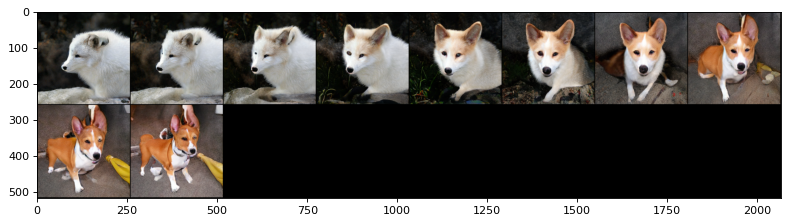

In [16]:
def interpolate_between_classes(model, class_names, num_intermediate_steps=8, truncation=0.4):
    # Prepare input
    class_vectors = one_hot_from_names(class_names, batch_size=len(class_names))
    noise_vectors = truncated_noise_sample(truncation=truncation, batch_size=len(class_names))

    alpha = np.linspace(0, 1, num_intermediate_steps + 2)  # Including start and end images
    interpolated_noise_vectors = [(1 - a) * noise_vectors[0] + a * noise_vectors[1] for a in alpha]
    interpolated_class_vectors = [(1 - a) * class_vectors[0] + a * class_vectors[1] for a in alpha]
    interpolated_noise_vectors = torch.tensor(interpolated_noise_vectors)
    interpolated_class_vectors = torch.tensor(interpolated_class_vectors)

    # All in tensors
    interpolated_noise_vectors = interpolated_noise_vectors.to('cuda')
    interpolated_class_vectors = interpolated_class_vectors.to('cuda')

    # Generate images
    with torch.no_grad():
        generated_images = model(interpolated_noise_vectors, interpolated_class_vectors, truncation)

    generated_images = generated_images.to('cpu')
    grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=True, normalize=True)
    plt.figure(figsize=(12, 6), dpi=80)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())

interpolate_between_classes(model, ['fox', 'dog'])


# Extra Credit Stable Diffusion Interpolations (8 points)

Experiment with the stable diffusion model (example notebook here https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb). For two prompts of your choosing sample the images and also create interpolations between two images of your choice (as in the above questions) they can be images of the same and different prompts. 

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

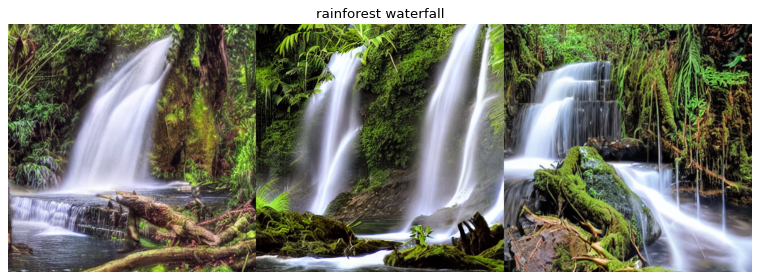

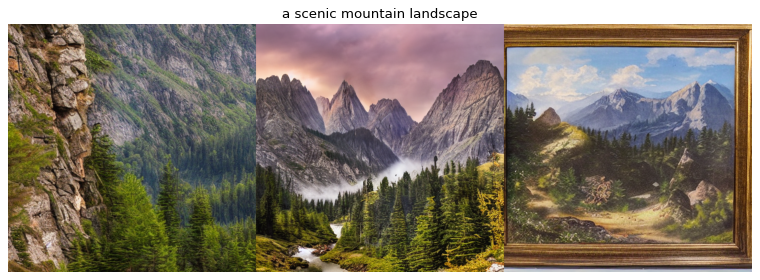

In [7]:
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float32)

def generate_images(prompt, num_images=1, seed=None):
    generator = torch.Generator("cuda").manual_seed(seed) if seed is not None else None
    images = [pipe(prompt, num_inference_steps=10, generator=generator).images[0] for _ in range(num_images)]
    return images

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

prompts = ["rainforest waterfall", "a scenic mountain landscape"]
num_images_per_prompt = 3
manual_seed = 42

generated_images = [generate_images(prompt, num_images=num_images_per_prompt) for prompt in prompts]

# Display generated images
for images, prompt in zip(generated_images, prompts):
    grid = image_grid(images, rows=1, cols=num_images_per_prompt)
    plt.figure(figsize=(12, 6), dpi=80)
    plt.title(prompt)
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

In [41]:
import numpy as np
import random
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from PIL import Image 
# from IPython.display import Image, display


pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    torch_dtype=torch.float16,
    safety_checker=None, 
    custom_pipeline="interpolate_stable_diffusion",
).to("cuda")
pipe.enable_attention_slicing()

images = pipe.walk(
    prompts=["rainforest waterfall", "a scenic mountain landscape"],
    seeds = [42, 42],
    num_interpolation_steps=8,
    output_dir="./images",
    num_inference_steps=36,
)


You have disabled the safety checker for <class 'diffusers_modules.git.interpolate_stable_diffusion.StableDiffusionWalkPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

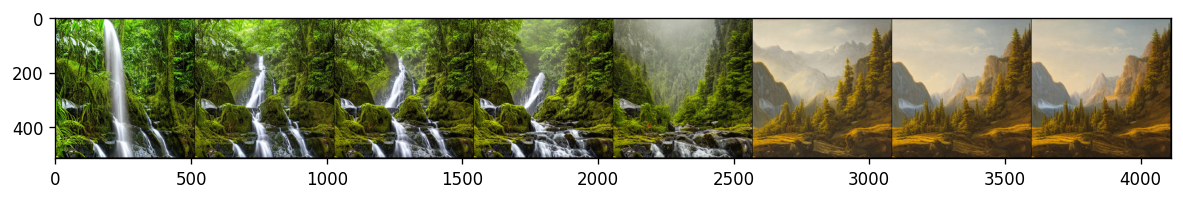

In [44]:
image_tensors = [ToTensor()(Image.open(image)) for image in images]
grid = make_grid(image_tensors, scale_each=True, normalize=True)
plt.figure(figsize=(12, 6), dpi=120)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())